# Self-Consistent Dust Reddening

In [1]:
%matplotlib inline

import os
import ares
import numpy as np
import matplotlib.pyplot as plt

In [Mirocha, Mason, & Stark (2020)](https://ui.adsabs.harvard.edu/abs/2020arXiv200507208M/abstract), we describe a simple extension to the now-standard galaxy model in ARES that generates ultraviolet colours self-consistently, rather than invoking IRX-$\beta$ relations to perform a dust correction. Here, we describe how to work with these new models.

### Preliminaries

Before getting started, two lookup tables are required that don't ship by default with ARES (via the ``ares download all`` command; [see ARES installation](../install.html)):

- A new halo mass function lookup table that employs the Tinker et al. 2010 results, rather than Sheth-Tormen (used in most earlier work with ARES).
- A lookup table of halo mass assembly histories.

This should only take a few minutes even in serial. We'll access some convenience routines in `ares.util.cli`. First, the new HMF tables:

In [2]:
kwargs = \
{
 "halo_mf": 'Tinker10',

 "halo_tmin": 30,
 "halo_tmax": 2e3,
 "halo_dt": 1,

 "cosmology_id": 'paul',
 "cosmology_name": 'user',
 "sigma_8": 0.8159,
 'primordial_index': 0.9652,
 'omega_m_0': 0.315579,
 'omega_b_0': 0.0491,
 'hubble_0': 0.6726,
 'omega_l_0': 1. - 0.315579,
}

HOME = os.environ.get('HOME')

from ares.util import cli

cli.generate_hmf_tables(f'{HOME}/.ares/halos', **kwargs)


############################################################################
##                           Halo Mass function                           ##
############################################################################
## ---------------------------------------------------------------------- ##
## Underlying Model                                                       ##
## ---------------------------------------------------------------------- ##
## fitting function       : Tinker10                                      ##
## ---------------------------------------------------------------------- ##
## Table Limits & Resolution                                              ##
## ---------------------------------------------------------------------- ##
## tmin (Myr)            : 30                                             ##
## tmax (Myr)            : 2000                                           ##
## dt   (Myr)            : 1                                              #

The new HMF table will use constant 1 Myr time-steps, rather than the default redshift steps, and employ a cosmology designed to remain consistent with another project (led by a collaborator whose name you can probably guess)!

Once you've done this, you should have a new file, ``halo_mf_Tinker10_user_paul_logM_1400_4-18_t_1971_30-2000.hdf5``, sitting inside ``$HOME/.ares/halos``. Now, we're almost done. Simply execute:

In [3]:
cli.generate_halo_histories(f'{HOME}/.ares/halos', 'halo_mf_Tinker10_user_paul_logM_1400_4-18_t_1971_30-2000.hdf5')


############################################################################
##                            Parameter Bundle                            ##
############################################################################
## UPDATE: Setting pq_func[0] -> dpl_evolNPSF                             ##
## [       previously pq_func[0] = dpl_normP]                             ##
## UPDATE: Setting pq_func_par0[0] ->  1.90e-02                           ##
## [       previously pq_func_par0[0] =  5.00e-02]                        ##
############################################################################
Read cosmology from halo_mf_Tinker10_user_paul_logM_1400_4-18_t_1971_30-2000.hdf5
Running new trajectories...
# Loaded halo_mf_Tinker10_user_paul_logM_1400_4-18_t_1971_30-2000.hdf5.
# Loaded $ARES/bpass_v1/SEDS/sed.bpass.constant.nocont.sin.z020
# Augmenting suite of halos at z_form=59.13
# Will generate halos with M0 up to M0=10.0*Mmin
Wrote halo_hist_Tinker10_user_paul_logM_1400

The additional resulting file, ``halo_hist_Tinker10_user_paul_logM_1400_4-18_t_1971_30-2000_xM_10_0.10.hdf5``, will be found automatically in subsequent calculations.

### Example


With the required lookup tables now in hand, we can get to it:

In [4]:
pars = ares.util.ParameterBundle('mirocha2020:univ')

Now, we create a ``GalaxyPopulation`` object,

In [5]:
pop = ares.populations.GalaxyPopulation(**pars)

which is an instance of the ``GalaxyEnsemble`` class, rather than the ``GalaxyCohort`` class, the latter of which is described in [this example](example_pop_galaxy). This offers a more general approach, including more complex star formation histories and proper treatment of spectral synthesis.

We can plot the UVLF in the usual way,

/Users/jmirocha/Work/soft/miniconda3/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


# Loaded $ARES/halos/halo_hist_Tinker10_user_paul_logM_1400_4-18_t_1971_30-2000_xM_10_0.10.hdf5.
# Loaded $ARES/halos/halo_mf_Tinker10_user_paul_logM_1400_4-18_t_1971_30-2000.hdf5.
# Loaded $ARES/bpass_v1/SEDS/sed.bpass.instant.nocont.sin.z004.deg10


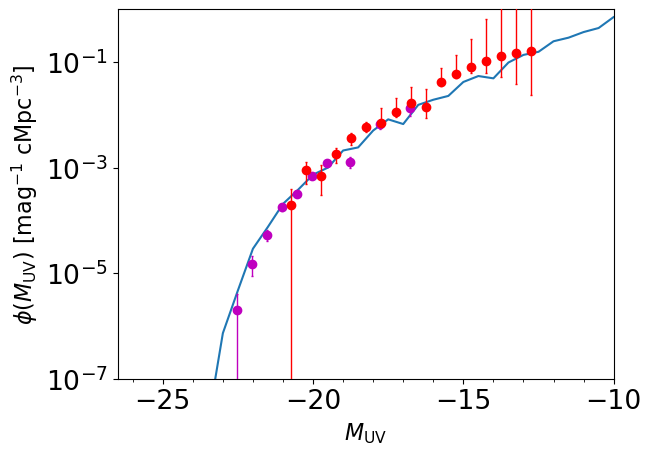

In [6]:
# First, some data
obslf = ares.analysis.GalaxyPopulation()
ax = obslf.PlotLF(z=6, round_z=0.2)

# Now, the predicted/calibrated UVLF
mags = np.arange(-30, 10, 0.5)
_mags, phi = pop.get_lf(6, mags, wave=1600)

ax.semilogy(mags, phi)

The main difference between these models and the simpler models (from, e.g., the ``mirocha2017`` parameter bundle) is access to UV colours. To access them, you can do, e.g., 

l(nu): 100% |###############################################| Time:  0:00:00 


<ErrorbarContainer object of 3 artists>

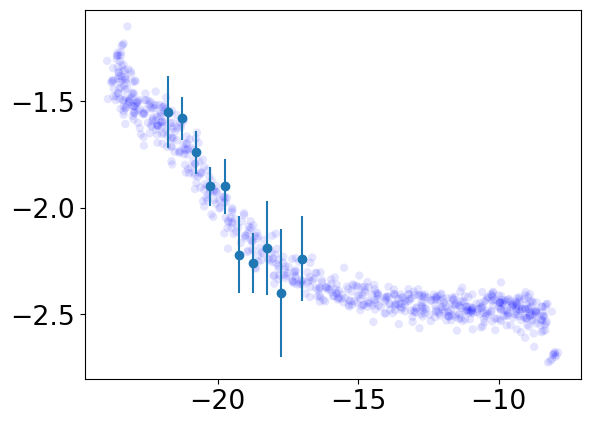

In [19]:
filt, mags = pop.get_mags(6., presets='hst', wave=1600.)
beta = pop.get_beta(6., presets='hst')

# `mags` will have the shape (len(filt), number of halos). 
# For z=6 galaxies, the bluest filter here F098M corresponds to ~1400A rest-frame
plt.scatter(mags[0], beta, alpha=0.1, color='b', edgecolors='none')

# For a comparison, go and grab Bouwens et al. 2014's constraints on Beta and plot
b14 = ares.data.read('bouwens2014')
plt.errorbar(b14.data['beta'][6]['M'], b14.data['beta'][6]['beta'], 
    yerr=b14.data['beta'][6]['err'], fmt='o')

This can take a few seconds, depending on the value of `pop_thin_hist`, as modeling UV colours requires synthesizing a reasonbly high resolution ($\Delta \lambda = 20 \unicode{x212B}$ by default) spectrum for each galaxy in the model so that there are multiple points within photometric windows. By default, `pop_thin_hist` is only 10 -- increasing this number will increase the number of galaxies modeled in each mass bin, and so smooth out the model's predictions.

This example computes the UV slope $\beta$ using the *Hubble* filters appropriate for the input redshift (see Table A1 in the paper).

**NOTE:** Other ``presets`` include ``'jwst'``, ``'jwst-w'``, ``'jwst-m'``, and ``'calzetti1994'``.

You can bin points in the $M_{\text{UV}}-\beta$ plane, if you prefer it, via the ``return_binned`` keyword argument,

l(nu): 100% |###############################################| Time:  0:00:00 


<ErrorbarContainer object of 3 artists>

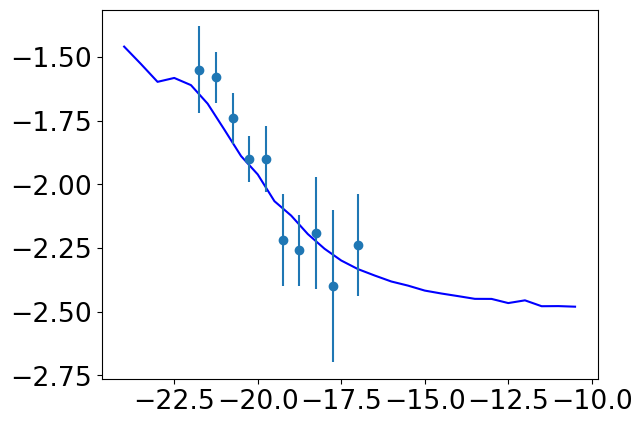

In [27]:
# Plot scatter in each MUV bin as errorbars
magbins = np.arange(-25, -10, 0.5) # bin centers
beta, beta_s = pop.get_beta(6., presets='hst', Mbins=magbins, return_binned=True,
    return_scatter=True)

plt.plot(magbins, beta, color='b')

# Plot some data for reference again.
plt.errorbar(b14.data['beta'][6]['M'], b14.data['beta'][6]['beta'], 
    yerr=b14.data['beta'][6]['err'], fmt='o')

**NOTE:** Computing colors from fits in the [Calzetti et al. 1994](https://ui.adsabs.harvard.edu/abs/1994ApJ...429..582C/abstract>) windows requires higher spectral resolution, given that these windows are each only $\Delta \lambda \sim 10 \unicode{x212B}$ wide. Adjust the ``dlam`` keyword argument to increase the wavelength-sampling used prior to photometric UV slope estimation.

Lastly, to extract the "raw" galaxy population properties, like SFR, stellar mass, etc., you can use the ``get_field`` method, e.g.,

In [22]:
Ms = pop.get_field(6., 'Ms') # stellar mass
Md = pop.get_field(6., 'Md') # dust mass
Sd = pop.get_field(6., 'Sd') # dust surface density
# etc.

To see what's available, check out

In [23]:
pop.histories.keys()

dict_keys(['nh', 'Mh', 'MAR', 't', 'z', 'children', 'zthin', 'SFR', 'Ms', 'MZ', 'Md', 'Sd', 'fcov', 'Mg', 'Z', 'bursty', 'pos', 'Nsn', 'rand'])

From these simple commands, most plots and analyses from the paper can be reproduced in relatively short order.

### Notes on performance

The compute time for these models is determined largely by three factors:

* The number of halos (really halo bins) we evolve forward in time. The default ``mirocha2020:univ`` models use $\Delta \log_{10} M_h = 0.01$ mass-bins, each with 10 halos (``pop_thin_hist=10``). For a larger sample, e.g., when lots of scatter is being employed, larger values of ``pop_thin_hist`` may be warranted.
* The number of observed redshifts at which $\beta$ is synthesize, since new spectra must be generated.
* The number of wavelengths used to sample the intrinsic UV spectrum of galaxies. When computing $\beta$ via photometry (Hubble or JWST), $\Delta \lambda = 20 \unicode{x212B}$ will generally suffice. 

For the models in [Mirocha, Mason, & Stark (2020)](https://ui.adsabs.harvard.edu/abs/2020arXiv200507208M/abstract>), with $\Delta \log_{10} M_h = 0.01$ (``hmf_logM=0.01``), ``pop_thin_hist=10``, calibrating at two redshifts for $\beta$ (4 and 6), with $\Delta \lambda = 20 \unicode{x212B}$, each model takes $\sim 10-20$ seconds, depending on your machine.

**NOTE:** Generating the UVLF is essentially free compared to computing $\beta$.

For more information on what's happening under the hood, e.g., with regards to spectral synthesis and noisy star-formation histories, see [Example: spectral synthesis](../example_pop_sps.html).
